In [1]:
%matplotlib inline
from google.cloud import storage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
import pandas as pd
import numpy as np

In [2]:
# Set up bucket

client = storage.Client()
bucket = client.get_bucket('catflap-photos-raw')

In [3]:
# Get list of blob names

blobs = bucket.list_blobs()
blob_list = [blob.name for blob in blobs]

In [4]:
# Create dataframe of blob names

blob_df = pd.DataFrame()
blob_df['name'] = pd.Series(blob_list)

print(blob_df.shape)
blob_df.head()

(13104, 1)


,name
0,2020-05-03_123920.jpy
1,2020-05-03_124751.jpy
2,2020-05-03_125032.jpy
3,2020-05-03_130442.jpy
4,2020-05-03_130550.jpy


In [5]:
# Filter blob list

blob_df = blob_df[blob_df.name.str.contains('jpg')]
blob_df = blob_df[blob_df.name.str.contains('2020-05')]

print(blob_df.shape)
blob_df.head()

(13060, 1)


,name
43,2020-05-07_220224.jpg
44,2020-05-07_220232.jpg
45,2020-05-07_220239.jpg
46,2020-05-07_220246.jpg
47,2020-05-07_220253.jpg


In [6]:
# Create pandas timestamp from blob names

blob_df['timestamp'] = pd.to_datetime(blob_df.name, format='%Y-%m-%d_%H%M%S.jpg')

blob_df.head()

,name,timestamp
43,2020-05-07_220224.jpg,2020-05-07 22:02:24
44,2020-05-07_220232.jpg,2020-05-07 22:02:32
45,2020-05-07_220239.jpg,2020-05-07 22:02:39
46,2020-05-07_220246.jpg,2020-05-07 22:02:46
47,2020-05-07_220253.jpg,2020-05-07 22:02:53


Text(0, 0.5, 'Photos per hour')

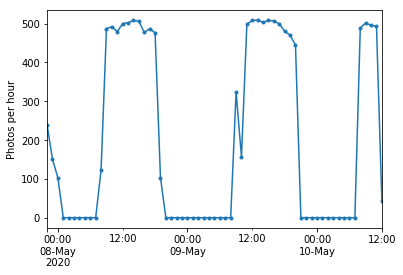

In [7]:
# Plot photos per hour

blob_df.groupby(pd.Grouper(freq='H', key='timestamp')).name.count().plot(style='.-')

plt.xlabel('')
plt.ylabel('Photos per hour')

In [8]:
# Get 10 minutes of objects

recent_blobs = blob_df[blob_df.name.str.contains('2020-05-09_114')].reset_index(drop=True)

print(recent_blobs.shape)
recent_blobs.head()

(79, 2)


,name,timestamp
0,2020-05-09_114001.jpg,2020-05-09 11:40:01
1,2020-05-09_114008.jpg,2020-05-09 11:40:08
2,2020-05-09_114015.jpg,2020-05-09 11:40:15
3,2020-05-09_114022.jpg,2020-05-09 11:40:22
4,2020-05-09_114029.jpg,2020-05-09 11:40:29


In [9]:
# Calculate stats for a subset of images

last_image = None
blob_stats_list = []
for blob_name in recent_blobs.name:
    
    # Read blob bytes into memory from GCS bucket
    blob = bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    
    blob_stats = {}
    
    # Colours
    mean_colours = np.mean(img, axis=(0,1))
    blob_stats['red'] = mean_colours[0]
    blob_stats['green'] = mean_colours[1]
    blob_stats['blue'] = mean_colours[2]
    
    # Frame diff
    frame_diff = np.nan
    if last_image is not None:
        frame_diff = np.sum(np.abs(img-last_image))
    blob_stats['frame_diff'] = frame_diff
    
    blob_stats_list += [blob_stats]
    last_image = img.copy()
    
blob_stats_df = pd.DataFrame(blob_stats_list)

print(blob_stats_df.shape)
blob_stats_df.head()

(79, 4)


,blue,frame_diff,green,red
0,111.963446,NaN,116.492958,116.966865
1,111.211044,172584754.0,116.546683,116.595779
2,111.511235,144029892.0,116.439421,116.976058
3,111.149746,154106409.0,117.111762,116.462625
4,112.306669,130423854.0,116.532129,117.368631


In [10]:
# Join blob names and stats together

stats_df = recent_blobs.merge(blob_stats_df, right_index=True, left_index=True)

print(stats_df.shape)
stats_df.head()

(79, 6)


,name,timestamp,blue,frame_diff,green,red
0,2020-05-09_114001.jpg,2020-05-09 11:40:01,111.963446,NaN,116.492958,116.966865
1,2020-05-09_114008.jpg,2020-05-09 11:40:08,111.211044,172584754.0,116.546683,116.595779
2,2020-05-09_114015.jpg,2020-05-09 11:40:15,111.511235,144029892.0,116.439421,116.976058
3,2020-05-09_114022.jpg,2020-05-09 11:40:22,111.149746,154106409.0,117.111762,116.462625
4,2020-05-09_114029.jpg,2020-05-09 11:40:29,112.306669,130423854.0,116.532129,117.368631


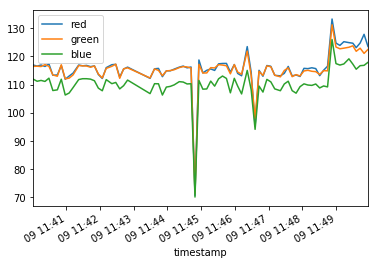

In [11]:
# Plot colour levels over time

colours = ['red','green','blue']
stats_df.set_index('timestamp')[colours].plot()

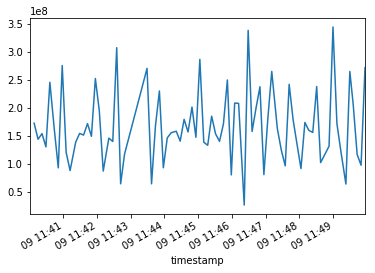

In [12]:
# Plot frame difference over time

stats_df.set_index('timestamp').frame_diff.plot()

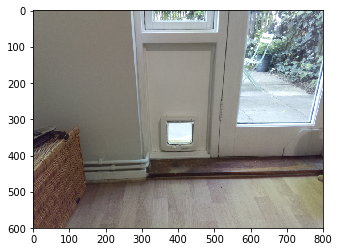

In [13]:
# Plot images

for blob_name in recent_blobs.name.iloc[-10:]:
    
    blob = bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    plt.figure()
    plt.imshow(img)
    
    break